In [1]:
import sys
sys.path.append('..')
from src.data.docx  import read_docx,process_docx,find_content
import glob
import json
import os
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore")
from src.features.segment_transcript import CreateBlocks
from functools import reduce
import heapq
from gensim.corpora import Dictionary
from gensim import models
from gensim import similarities
import re
import statistics
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, HTML

# READ BOOKS OF VIDEOS

In [2]:
'''Defining CONSTS'''
docx_path = '../data/raw/docx'
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')

In [3]:
videos_ids = list(map(lambda fl: fl.split('\\')[-1].split('.')[0],glob.glob(docx_path + '/*')))

In [4]:
desired_videos =['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ','zWg7U0OEAoE','tORLeHHtazM'] #['zWg7U0OEAoE','tORLeHHtazM'] #['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ']
videos_ids = list(filter(lambda x: x in desired_videos,videos_ids))

In [5]:
#video_docx = [glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0] for vid in videos_ids]
#docx_db =[read_docx(path) for path in video_docx]

In [6]:
f_read = {
    'statbook':'statbook',
    'Dsa':'Dsa'
}

docxs_chapter_keyword = {
    'statbook':'Topic',
    'Dsa': 'Chapter'
}

In [7]:
video_to_paper = {}
paper_content ={}
for vid in videos_ids:
    doc_path = glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0]
    doc_name = doc_path.split('\\')[-1].split('.')[0]
    video_to_paper[vid] = doc_name    
    if doc_name not in paper_content.keys():    
        full_text,font_sizes = read_docx(doc_path)
        paper_content[doc_name] = find_content(f_read[doc_name],
                                               full_text,
                                               font_sizes,
                                               docxs_chapter_keyword[doc_name])

In [8]:
"""#transcript_filespath
#videos_ids
from docx import *
word_document = Document(doc_path)
p_sent = re.compile('\w+')
full_text = []
font_sizes = []
for para in word_document.paragraphs:
    for i,run in enumerate(para.runs):        
        matching = p_sent.match(run.text)

        # see if there is a number or letter ( it is not a trash)
        if matching is not None and run.text is not None and run.font.size is not None:
                full_text.append(re.sub('[\t\n\b\r]','',run.text))
"""

"#transcript_filespath\n#videos_ids\nfrom docx import *\nword_document = Document(doc_path)\np_sent = re.compile('\\w+')\nfull_text = []\nfont_sizes = []\nfor para in word_document.paragraphs:\n    for i,run in enumerate(para.runs):        \n        matching = p_sent.match(run.text)\n\n        # see if there is a number or letter ( it is not a trash)\n        if matching is not None and run.text is not None and run.font.size is not None:\n                full_text.append(re.sub('[\t\n\x08\r]','',run.text))\n"

# RESTORE RESULTS FROM TRAINING

In [9]:
'''Select transcript for only wanted videos'''
transcript_filespath = list(filter(lambda x: x.split('\\')[-1].split('.')[0] in videos_ids,transcript_filespath))

'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript
#print(transcripts_jsons)

'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

''' Transfer topic shifts time to seconds units instead HH:MM:SS'''
def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec
for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])
    
    
def boundryevaluation(curresults,ground_base,accurrcy_shift = 30):
        true_positive = 0
        false_negative = 0
        false_positive = 0 
        true_positive_list_debug = []
        #false_negative_list_debug = []
        false_positive_list_debug = []
        results = curresults[:]
        
        
        #print('curresults %s' %(curresults))
        #print('ground_base %s ' %(ground_base))
        
        for grb in ground_base:
            is_false_positive = True
            for res in results:     
                if abs(res - grb) < accurrcy_shift:
                    is_false_positive = False
                    true_positive_list_debug.append(res)
                    true_positive+=1
                    results.remove(res)
                    break   
            if is_false_positive:
                false_positive_list_debug.append(grb)
                false_positive+=1
                
        #print("TP: " + str(true_positive_list_debug))
        #print("FP: " + str(false_positive_list_debug))
        #print("FN: " + str(curresults))
        #print('true_positive : %s ' %(true_positive))
        false_negative = len(results) # make sure the true positive are removed from here 
        recall_rate = true_positive/(true_positive + false_negative )
        precision_rate = true_positive/(true_positive + false_positive)
        #print("TP: %s , FP: %s, FN: %s" %(true_positive,false_positive,false_negative))
        #print("precision rate : %s, recall rate : %s " % (precision_rate,recall_rate))
        return precision_rate

    
videos_division = {}

for vid in videos_ids:
    vid_words = None
    vid_shifts = None
    shifts = df_videos.loc[df_videos['video id'] == vid,'topic shifts(ends)'].values.tolist()
    groundbase = shifts[:-2]
    transcripts = transcripts_jsons[vid]
    print(vid)
    print(groundbase)
    print(transcripts[-1])
    block_handler = CreateBlocks(transcripts)
    block_as_topics = block_handler.partion_by_timestamp(groundbase)
    vid_words = [list(blk) for blk in block_as_topics]
    groundbase.append('end')
    videos_division[vid] = {'topic_words':vid_words,'topic_shift':groundbase}

7kLHJ-F33GI
[170, 299, 647, 735, 871, 1161, 1433, 1662, 1858, 2437]
{'text': 'these socials', 'start': 2557.07, 'duration': 3.56}
7snJ1mx1EMQ
[390, 840, 1140, 1260, 1365, 1565]
{'text': 'we will continue in the subsequent model Thank\nyou very much', 'start': 1948.799, 'duration': 8.81}
RIawrYLVdIw
[265, 519, 1329, 1833, 2220, 2308, 2545]
{'text': 'see you next week', 'start': 2926.78, 'duration': 3.39}
tORLeHHtazM
[91, 410, 513, 807, 966, 1394, 1604, 1942, 2234]
{'text': 'of trees.', 'start': 2592.02, 'duration': 1.38}
zWg7U0OEAoE
[149, 233, 503, 791, 1476, 1836, 2036, 2155, 2221, 2350, 2494, 2761]
{'text': 'and terminology that we be following with\nthis course.', 'start': 3175.91, 'duration': 34.75}


7kLHJ-F33GI
[170, 299, 647, 735, 871, 1161, 1433, 1662, 1858, 2437]
{'text': 'these socials', 'start': 2557.07, 'duration': 3.56}
7snJ1mx1EMQ
[390, 840, 1140, 1260, 1365, 1565]
{'text': 'we will continue in the subsequent model Thank\nyou very much', 'start': 1948.799, 'duration': 8.81}
RIawrYLVdIw
[265, 519, 1329, 1833, 2220, 2308, 2545]
{'text': 'see you next week', 'start': 2926.78, 'duration': 3.39}
tORLeHHtazM
[91, 410, 513, 807, 966, 1394, 1604, 1942, 2234]
{'text': 'of trees.', 'start': 2592.02, 'duration': 1.38}
zWg7U0OEAoE
[149, 233, 503, 791, 1476, 1836, 2036, 2155, 2221, 2350, 2494, 2761]
{'text': 'and terminology that we be following with\nthis course.', 'start': 3175.91, 'duration': 34.75}


In [10]:
#videos_division

# EXTRACT MAIN CHAPTERS OF BOOKS AND ORAGANIZE THE PAPER AS DIFFERENT DOCUMENTS GROUPS

In [10]:
paper_content[doc_name].keys()

dict_keys(['corpus', 'titles', 'main titles'])

In [11]:
'''Find the following for each paper:
    1) main chapter title index. for example [10,15....]
    2) range of subsection within each main chapter . for example [(0,9),(11,14)...]
    
    '''

paper_mainchapter_indexes = {}
paper_sec_within_main_indexes = {}
paper_mains_as_one_doc = {}
paper_subsec_as_one_doc = {}

for doc_name in paper_content.keys():
    '''Find the main chapter indexes in the list of the overall titles'''
    mainchapter_indexes = [paper_content[doc_name]['titles'].index(ch_title)
                           for ch_title in paper_content[doc_name]['main titles']]
    '''Find the subsection indexes range within each main chapter '''
    subsec_mainchapter_indexes = [range(mainchapter_indexes[index],mainchapter_indexes[index + 1])
                                  for index in range(len(mainchapter_indexes) - 1)]
    subsec_mainchapter_indexes.append(range(mainchapter_indexes[-1],
                                            len(paper_content[doc_name]['titles'])))
    paper_mainchapter_indexes[doc_name] = mainchapter_indexes
    paper_sec_within_main_indexes[doc_name] = subsec_mainchapter_indexes
    
    
    '''Making each chapter as a one documents'''
    
    '''Union all the documents in a section into single document'''
    paper_subsec_as_one_doc[doc_name] = [list(reduce(lambda doc,acc:doc + acc,sec,[]))
                                         for sec in paper_content[doc_name]['corpus']]
    '''Union all the sub section in a main chapter into one document'''
    paper_mains_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                    paper_subsec_as_one_doc[doc_name][s_i]+acc,subsec_indexes,[]))
                                        for subsec_indexes in paper_sec_within_main_indexes[doc_name]]

In [12]:
#paper_subsec_as_one_doc['statbook'][0]

In [13]:
'''Debug'''
"""
print(paper_content['statbook']['main titles'])
print((paper_content['statbook']['titles']))
print(len(paper_content['statbook']['titles']))# 
print(len(paper_content['statbook']['corpus']))#members of each element:section corpus
print(len(paper_content['statbook']['corpus'][0]))#members of each element: documents
print(len(paper_content['statbook']['corpus'][0][0])) #of each element words
print(paper_sec_within_main_indexes['statbook'])


#debug
print(sum([len(paper_subsec_as_one_doc['statbook'][s]) for s in range(0,10)]))
print(len(paper_mains_as_one_doc['statbook'][0]))
print(len(paper_mains_as_one_doc['statbook']))



"""
"""#print(len(paper_subsec_as_one_doc['statbook']))
print((subsec_mainchapter_indexes))
print(len(paper_content['Dsa']['titles']))
print(len(paper_subsec_as_one_doc[doc_name]))
print(len(paper_sec_within_main_indexes[doc_name]))
print(paper_content['Dsa']['titles'][-1])
print(paper_subsec_as_one_doc[doc_name][-2])
"""
"""print(paper_content['Dsa']['main titles'][0])
print(len(paper_mains_as_one_doc['Dsa'][0][0]))
print((paper_mains_as_one_doc['Dsa'][0][0]))
#print(len(paper_sec_within_main_indexes['Dsa'][0][0]))
print(len(paper_subsec_as_one_doc['Dsa'][0]))
print((paper_subsec_as_one_doc['Dsa'][0][0]))
print(len(videos_division['tORLeHHtazM']['topic_words'][0][0]))
print((videos_division['tORLeHHtazM']['topic_words'][0][0]))"""

#paper_content['Dsa']['corpus']
print((paper_mains_as_one_doc['Dsa'][0][0]))

flnal


In [14]:
'''Find phrasers of books  '''
paper_phrasers = {}
for doc_name in paper_mains_as_one_doc.keys():
    paper_phrasers[doc_name] = list(set(reduce(lambda acc,x: acc+x,
                                      [[w for w in ch if '_' in w]
                                      for ch in paper_mains_as_one_doc[doc_name]])))

In [15]:
#paper_phrasers['Dsa']

# FIND CORRELATION BETWEEN MAIN CHAPTERES AND FOUNDED TOPICS IN THE VIDEO 

In [16]:
def find_top_words_of_topic(topic_words,chapter_titles=None):
    for tp_i,tp_words in enumerate(topic_words):
        #
        raw_text = ' '.join(tp_words)
        myvectorizer = CountVectorizer()
        mytf = myvectorizer.fit_transform([raw_text]).toarray()
        #print(mytf)
        maxes = heapq.nlargest(3,mytf[0])
        indexes = []
        for i,bal in enumerate(mytf[0]):
            if bal in maxes:
                indexes.append(i)
        ws = [myvectorizer.get_feature_names()[_] for i,_ in enumerate(indexes)]
        
        if chapter_titles is None:
            print('top words for topic %s are %s' %(tp_i,ws))
        else:
            print('top words for topic %s are %s' %(chapter_titles[tp_i],ws))

In [17]:
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import spacy
stop_words = stopwords.words('english')
nlp = spacy.load('en',disable=['parser','ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB','PROPN','ADV']#['NOUN', 'ADJ', 'VERB','ADV']#['NOUN', 'ADJ', 'VERB','PROPN']#['NOUN', 'ADJ', 'VERB'] #['NOUN', 'ADJ', 'VERB','PROPN','ADV']

In [18]:
def emphasize_title(doc_name,book_chapters,titles,factor_enrich = 20):
    chapters_enriched = book_chapters[:]
    
    for index,tl in enumerate(titles):
        tl_text_no_punc = simple_preprocess(tl,deacc=True) 
        tokenized_text_non_stop_words = [ word for word in tl_text_no_punc 
                                         if word not in stop_words]
        text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
        tokenized_lemmas = nlp(text_non_stop_words)
        tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                            if token.pos_ in allowed_postags]
        
        tokenized_lemmas_ph = '_'.join(tokenized_lemmas)#reduce(lambda acc,x: acc+x,
        #print('tokenized_lemmas_ph %s' %(tokenized_lemmas_ph))
        
        if tokenized_lemmas_ph in paper_phrasers[doc_name]:
            tokenized_lemmas =[tokenized_lemmas_ph]
        
        chapters_enriched[index] = chapters_enriched[index] + tokenized_lemmas * factor_enrich
    return chapters_enriched

In [19]:
def get_topic_chapter_corr_tfidf(paper_name,book_chapters,
                                 vid_topics_words,vid_topics_shift,
                                 dispaly_titles,pre_labeled_title=None):
    raw_book_video = []
    for tp_vid in vid_topics_words:
        raw_book_video = raw_book_video + [tp_vid]
    
    for ch in book_chapters:
        raw_book_video = raw_book_video + [ch]

    # creating dictionary of all of the words in the corpus of the video and the paper
    #print(len(raw_book_video))
    dictionary = Dictionary(raw_book_video)
    #dictionary = Dictionary(book_chapters)
    
    #ch_dict = Dictionary(book_chapters)
    #vid_dict = Dictionary(vid_topics_words)
    
    the_dictionary = dictionary
    
    #whole_corpus = vid_topics_words + book_chapters
    #bgw_corpus = [dictionary.doc2bow(doc) for doc in whole_corpus]
    bgw_chapter = [the_dictionary.doc2bow(doc) for doc in book_chapters]
    bgw_vids = [the_dictionary.doc2bow(doc) for doc in vid_topics_words]
    
    '''Calculate the pivot '''
    _tmp =  [len(list(set([w for w in ch]))) for ch in book_chapters]
    book_pivot = sum(_tmp)/len(_tmp)
    _tmp = [len(list(set([w for w in ch]))) for ch in vid_topics_words]
    vid_pivot = sum(_tmp)/len(_tmp)
    
    tf_idf_model_ch = models.TfidfModel(bgw_chapter,
                                        dictionary=the_dictionary#,
                                        #pivot=book_pivot,
                                        #slope=0.8,
                                        #smartirs='nnc'
                                       ) #,
    tf_idf_model_vid = models.TfidfModel(bgw_vids,
                                         dictionary=the_dictionary#,
                                         #pivot=vid_pivot,
                                         #slope=0.4
                                        )#,smartirs='lfc'
    
    index_sim = similarities.SparseMatrixSimilarity(tf_idf_model_ch[bgw_chapter],
                                                    num_features=len(the_dictionary))
    
    correlation = [[s for s in index_sim[tf_idf_model_vid[doc]]] for doc in bgw_vids]
    #print(tf_idf_model[bgw_vids])
    
    # find the top n words in the topic (in the video)
    #print('$$$$$$$$$$$$$$top words of video topic$$$$$$$$$$$$$$')
    #find_top_words_of_topic(videos_division[vid]['topic_words'])
    #print('$$$$$$$$$$$$$$top words of book chapters$$$$$$$$$$$$$$')
    #find_top_words_of_topic(book_chapters,chapter_titles=dispaly_titles)
    
    
    
    # normalizing the correlation between each topic and chapter 
    for i_t in range(len(correlation)):
        sum_ = sum(correlation[i_t])
        for ch_index in range(len(correlation[i_t])):
            correlation[i_t][ch_index] = correlation[i_t][ch_index]/sum_
    
    corr_as_row = reduce(lambda x,y: x+y,correlation,[] ) # to get the global max in min
    sns.heatmap(correlation,vmin=min(corr_as_row),vmax=max(corr_as_row))
    plt.show()
    
    
    
    # find the cha
    ch_matching_top = []
    #print(len(correlation[0]))
    
    
    for i,corr in enumerate(correlation):
        max_cor = max(corr) # max correlation with that topic
        shift = vid_topics_shift[i]
        founded_title = dispaly_titles[corr.index(max_cor)]
        #ch_matching_top.append(paper_mainchapter_indexes[paper_name][corr.index(max_cor)])
        ch_matching_top.append(founded_title)

    
    
    hit = 0 
    miss = 0
    
    if pre_labeled_title is not None:
        print(vid)
        df_vid_results = pd.DataFrame(columns=['Video',
                                               'Video Shift',
                                               'Founded Title',
                                               'Similarity Ratio',
                                               'Chapter Section',
                                               'Prelabeled Title',
                                               'Labeling Confidence'])
        for i,corr in enumerate(correlation):
            max_cor = max(corr) # max correlation with that topic
            shift = vid_topics_shift[i]
            founded_title = dispaly_titles[corr.index(max_cor)]
            df_vid_results = df_vid_results.append({
                                   'Video' :vid,
                                   'Video Shift': sec_to_min(shift),
                                   'Founded Title':founded_title,
                                   'Similarity Ratio':max_cor,
                                   'Chapter Section':pre_labeled_title[i][0],
                                   'Prelabeled Title':pre_labeled_title[i][1],
                                   'Labeling Confidence':pre_labeled_title[i][2]},ignore_index=True)

        display(HTML(df_vid_results[['Video Shift',
                                    'Founded Title',
                                    'Similarity Ratio',
                                    'Chapter Section',
                                    'Prelabeled Title',
                                    'Labeling Confidence']].to_html()))

    return ch_matching_top,correlation

def find_dominent_main_chapter(ch_tp_corr,titles,correlation):
    
    '''Find the frequency of each chapter'''
    chapter_matching_counts_max = [max([ch_tp_corr.count(ch) for ch in ch_tp_corr])]
    for max_count in chapter_matching_counts_max:
        #print("####### #######")
        '''Find the most frequent chapter'''
        #print(([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        dominent_chapters = list(set([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        #print(dominent_chapters)
        
        # if we have absulote majority on topic
        if len(dominent_chapters) == 1:
            return dominent_chapters[0]
        else:
            """max_value = 0
            title_max =None
            for j,ch in dominent_chapters:
                cor = sum(ch_tp_corr[j])
                if cor > max_value:
                    max_value= cor
                    title_max = ch
            return title_max"""
            
            # draw between topics, decide which one by taking this with the high variance
            index_winner = 0
            df_ch_corr = pd.DataFrame.from_records(correlation)
            for j_dom in range(len(dominent_chapters)):
                first = df_ch_corr.var()[titles.index(dominent_chapters[index_winner])]
                #print(first)
                second = df_ch_corr.var()[titles.index(dominent_chapters[j_dom])]
                #print(second)
                if first < second:
                    index_winner = j_dom
            return (dominent_chapters[index_winner])
        
            
        
def sec_to_min(seconds):
    if seconds == 'end':
        return 'end'
    return ("%02d:%02d"%(seconds//60,seconds%60))

# correlations : correaltions of all levels
def measure_confidence(vid,correlations):
    n_vid_topic = len(correlations[0]) # number of video topics that were found
    topics_errs = []
    for topic_index in range(n_vid_topic):
        topic_pr = 0
        for map_index,correlation_map in enumerate(correlations):
            '''Calculate soft max on the correlation of the current topic to the chapters'''
            #print('correlation %s map %s' % (topic_index,correlation_map[topic_index]))
            sum_ = sum(correlation_map[topic_index])
            max_corr_ch_val = max(correlation_map[topic_index])
            #most_corr_ch_index = correlation_map[topic_index].index(max_corr_ch_val)
            most_corr_ch_val = max_corr_ch_val/sum_
            #print('max_val : %s sum_ : %s value from softmax : %s '%(max_corr_ch_val,sum_,most_corr_ch_val))
            '''scaling the max value by the cosine value of the max correlated'''
            most_corr_ch_val = most_corr_ch_val * max_corr_ch_val
            '''adding and scaling the given value to the overall rate of the topic'''
            topic_pr += (2**(-(map_index - 1))) * most_corr_ch_val
        print("For topic number %s the confidence is %s " % (topic_index,topic_pr))
        topics_errs.append(topic_pr)

In [20]:
df_tp_to_ch = pd.read_csv(os.path.join(groundbase_dir,'Topic to chapter.csv'))
df_tp_to_ch  = df_tp_to_ch.replace({np.nan:None})
#df_tp_to_ch.loc[df_tp_to_ch['video id'] == '7kLHJ-F33GI',
#                ['chapter section','chapter title','chapter confidence']].values[0].tolist()

################ 7kLHJ-F33GI ################


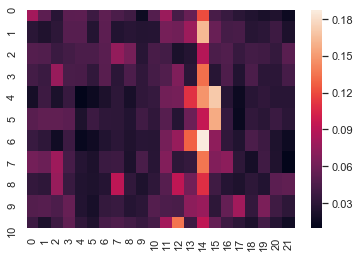

By the majority vote, the dominent chapter choosed is Maximum Likelihood Estimation 


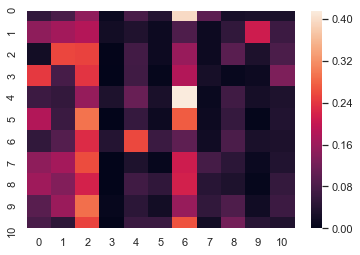

7kLHJ-F33GI


,Video Shift,Founded Title,Similarity Ratio,Chapter Section,Prelabeled Title,Labeling Confidence
0,02:50,15.6 Multidimensional Estimation,0.397226,None,None,None
1,04:59,15.9 Technical Aspects,0.210163,"15.1,15",Introduction,0.8
2,10:47,15.1,0.255864,15.2,example,0.9
3,12:15,Maximum Likelihood Estimation,0.243779,15.1,Introduction,0.2
4,14:31,15.6 Multidimensional Estimation,0.415224,15.6,multidimensional estimation,0.3
5,19:21,15.2 Examples,0.292804,15.2,example,None
6,23:53,15.4 Asymptotic Properties,0.257853,15.4,asymtotic properties,0.3
7,27:42,15.2 Examples,0.259821,None,None,None
8,30:58,15.2 Examples,0.217774,15.6,multidimensional estimation,None
9,40:37,15.2 Examples,0.290239,15.2,example,None


################ 7snJ1mx1EMQ ################


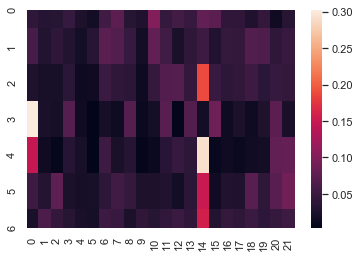

By the majority vote, the dominent chapter choosed is Maximum Likelihood Estimation 


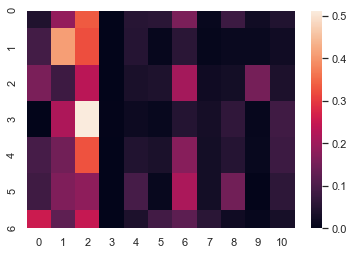

7snJ1mx1EMQ


,Video Shift,Founded Title,Similarity Ratio,Chapter Section,Prelabeled Title,Labeling Confidence
0,06:30,15.2 Examples,0.333872,15.2,example,0.8
1,14:00,15.1,0.409811,"15.2,15.1","example,Introduction",0.8
2,19:00,15.2 Examples,0.233807,15.1,Introduction,0.8
3,21:00,15.2 Examples,0.511575,15.1,Introduction,0.8
4,22:45,15.2 Examples,0.327169,15.1,Introduction,0.8
5,26:05,15.6 Multidimensional Estimation,0.217451,"15.2,15.1","example,Introduction",0.8
6,end,Maximum Likelihood Estimation,0.255895,15.2,example,0.8


################ RIawrYLVdIw ################


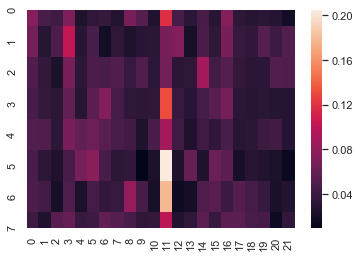

By the majority vote, the dominent chapter choosed is Overview of Estimation 


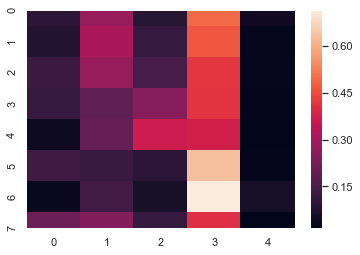

RIawrYLVdIw


,Video Shift,Founded Title,Similarity Ratio,Chapter Section,Prelabeled Title,Labeling Confidence
0,04:25,12.3 Bayesian Statistics,0.494988,None,None,None
1,08:39,12.3 Bayesian Statistics,0.467808,15.1,Introduction,None
2,22:09,12.3 Bayesian Statistics,0.419510,"15.2,15.1","example,Introduction",None
3,30:33,12.3 Bayesian Statistics,0.418830,12.3,bayesian statistics,0.8
4,37:00,12.3 Bayesian Statistics,0.377206,12.3,bayesian statistics,0.8
5,38:28,12.3 Bayesian Statistics,0.632262,12.3,bayesian statistics,0.8
6,42:25,12.3 Bayesian Statistics,0.713127,12.3,bayesian statistics,0.8
7,end,12.3 Bayesian Statistics,0.409259,12.3,bayesian statistics,0.8


################ tORLeHHtazM ################


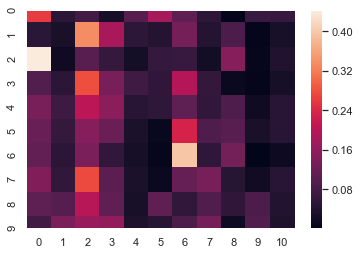

By the majority vote, the dominent chapter choosed is Binary Search Tree 


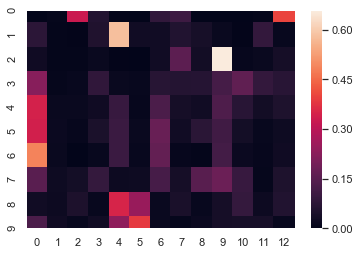

tORLeHHtazM


,Video Shift,Founded Title,Similarity Ratio,Chapter Section,Prelabeled Title,Labeling Confidence
0,01:31,3.8\tSummary,0.401863,3,binary search trees,0.6
1,06:50,3.4\tFinding the parent of a given node,0.580613,3,binary search trees,0.6
2,08:33,3.7.2\tPostorder,0.657287,3,binary search trees,0.9
3,13:27,Binary Search Tree,0.224473,3,binary search trees,0.6
4,16:06,Binary Search Tree,0.344505,3,binary search trees,0.6
5,23:14,Binary Search Tree,0.340637,None,None,None
6,26:44,Binary Search Tree,0.486342,None,None,None
7,32:22,3.7.2\tPostorder,0.180525,None,None,None
8,37:14,3.4\tFinding the parent of a given node,0.349504,None,None,None
9,end,3.5\tAttaining a reference to a node,0.385523,3,binary search trees,0.6


################ zWg7U0OEAoE ################


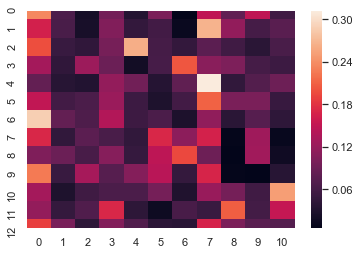

By the majority vote, the dominent chapter choosed is Introduction 


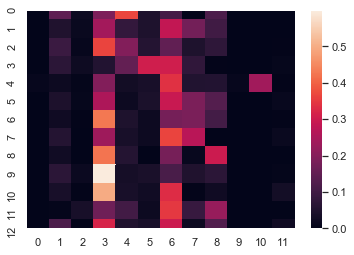

zWg7U0OEAoE


,Video Shift,Founded Title,Similarity Ratio,Chapter Section,Prelabeled Title,Labeling Confidence
0,02:29,1.2.2\tImperative programming language,0.367235,1.1,What this book is about,0.4
1,03:53,1.3\tPseudocode,0.284838,1.1,What this book is about,0.4
2,08:23,1.2.1\tBig Oh notation,0.365737,1.2.1,Big oh notation,0.7
3,13:11,1.2.3\tObject oriented concepts,0.307759,1.3,Pseudocode,1
4,24:36,1.3\tPseudocode,0.340540,None,None,None
5,30:36,1.3\tPseudocode,0.294584,None,None,None
6,33:56,1.2.1\tBig Oh notation,0.428401,1.2.1,Big oh notation,0.7
7,35:55,1.3\tPseudocode,0.364590,1.2.1,Big oh notation,0.7
8,37:01,1.2.1\tBig Oh notation,0.424040,1.2.1,Big oh notation,0.7
9,39:10,1.2.1\tBig Oh notation,0.597444,1.2.1,Big oh notation,0.7


In [21]:
chapters_matching_topics = {}
for vid in videos_ids:
    print('################ %s ################' % (vid))
    paper_name = video_to_paper[vid]
    correlations_levels = []
    
    #################################################
    '''Extracting the prelabeled topics to chapters'''
    #################################################
    '''Extracting all pre labeled topics '''
    pre_labeled_titles = df_tp_to_ch.loc[df_tp_to_ch['video id'] == vid,
                        ['chapter section','chapter title','chapter confidence']].values.tolist()
    
    '''Extracting prelabel for main titles'''
    '''level = 0 
    pre_labeled_main_titles = []
    for label in pre_labeled_titles:
        # if no correlation was given 
        main_section = None
        main_section_tl = None
        if label[0] is not None:
            main_section = int(str(label[0]).split('.')[level])
            main_section_tl = paper_content[paper_name]['main titles'][main_section -1]
        pre_labeled_main_titles.append([main_section,
                                        main_section_tl,
                                        label[2]])'''
    
    
    '''Finding the correlation between topic and main chapters'''
    main_matching_topic,correlation = get_topic_chapter_corr_tfidf(paper_name,
                                 paper_mains_as_one_doc[paper_name],
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 paper_content[paper_name]['main titles']
                                                                  )
    
    correlations_levels.append(correlation)
    #print(main_matching_topic)
    dominet_chapter =  find_dominent_main_chapter(main_matching_topic,
                                                  paper_content[paper_name]['main titles'],
                                                 correlation)
    print('By the majority vote, the dominent chapter choosed is %s ' %(dominet_chapter))
    
    #Searching for each topic the most correlated 
    #subsection to a topic within the dominent main chapter '''
    dom_main_cha_index = paper_content[paper_name]['main titles'].index(dominet_chapter)
    dom_subsec_text = [paper_subsec_as_one_doc[paper_name][s_i] for s_i in
                      paper_sec_within_main_indexes[paper_name][dom_main_cha_index]]
    dom_subsec_titles = [paper_content[paper_name]['titles'][tl]
                         for tl in paper_sec_within_main_indexes[paper_name][dom_main_cha_index]]
    
    dom_subsec_text = emphasize_title(paper_name,dom_subsec_text,dom_subsec_titles)
    
    subsec_matching_topic,correlation = get_topic_chapter_corr_tfidf(paper_name,
                                 dom_subsec_text,
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 dom_subsec_titles,
                                 pre_labeled_title = pre_labeled_titles)
    
    correlations_levels.append(correlation)
    #measure_confidence(vid,correlations_levels)
    
    
    
    
    